In [1]:
from random import gauss
import matplotlib.pyplot as plt
import numpy as np
from control import *

def rms(x):
    return((np.average(x**2)-np.average(x)**2)**0.5)


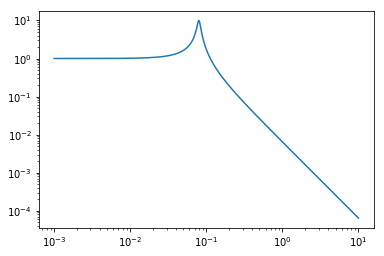

In [2]:
wn = 0.08*2*np.pi
Q = 10
IP_tf = tf([wn**2], [1, wn/Q, wn**2])
f = np.linspace(0.001, 10, 10000)
# t, x_IP_seismic, _ = forced_response(IP_tf, U=x_seismic, T=t)
plt.loglog(f, abs(IP_tf.horner(2*np.pi*f*1j)[0][0]))
# plt.vlines(0.2, 0.2,1)

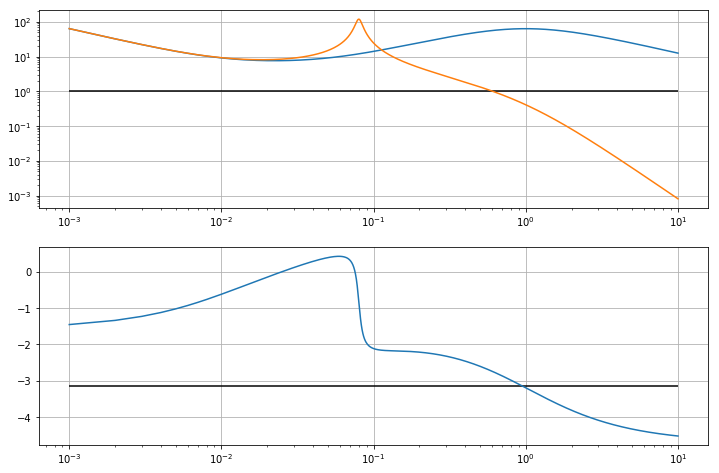

In [3]:
K=tf([1],[1,0])
K*=tf([1,0.01*2*np.pi],[0.01*2*np.pi])
K*=tf([1,0.05*2*np.pi],[0.05*2*np.pi])
K*=tf([1],[1/1/2/np.pi,1])**2
K*=0.4
OLTF=K*IP_tf
plt.figure(figsize=(12,8))
plt.subplot(211)
plt.loglog(f, abs(K.horner(2*np.pi*f*1j)[0][0]))
plt.loglog(f, abs(OLTF.horner(2*np.pi*f*1j)[0][0]))
plt.hlines(1, 1e-3,1e1)
plt.grid()
plt.subplot(212)
plt.semilogx(f, unwrap(np.angle(OLTF.horner(2*np.pi*f*1j)[0][0])))
plt.hlines(-np.pi, 1e-3,1e1)
plt.grid()


In [4]:
fs = 16  # 16 Hz
t = np.linspace(0, 500, 500*fs)
x_seismic = np.array([gauss(mu=0, sigma=0.5) for i in t])
x_seismic += 0.5/0.707*np.sin(0.2*2*np.pi*t)

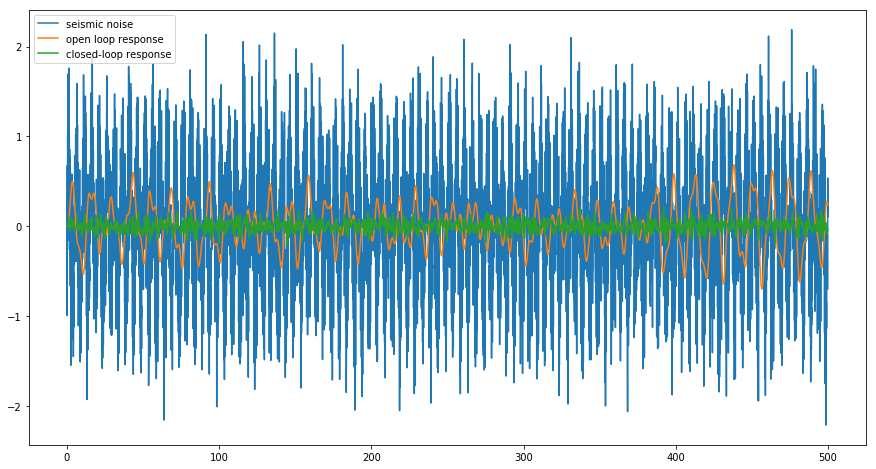

In [5]:
t, x_IP_open, _ = forced_response(IP_tf, U=x_seismic, T=t)

noise_lvdt = np.array([gauss(mu=0, sigma=0.1) for i in t])
noise_seismometer= np.array([gauss(mu=0, sigma=0.2) for i in t])
# noise_lvdt = lambda a: a*x_seismic
# perturbation=0.8+0.1*np.sin(0.08*2*np.pi*t)
# noise_lvdt_perturbed = x_seismic-[x_seismic[i]*perturbation[i] for i in range(len(t))]
# print(noise_lvdt_perturbed)
t, x_IP_closed_seismic, _ = forced_response(IP_tf/(1+OLTF), U=x_seismic, T=t)
t, x_IP_closed_sensor, _ = forced_response(OLTF/(1+OLTF), U=noise_lvdt, T=t)
# t, x_IP_closed_perturbed_sensor, _ = forced_response(OLTF/(1+OLTF), U=noise_lvdt_perturbed, T=t)

x_IP_closed = x_IP_closed_seismic + x_IP_closed_sensor

plt.figure(figsize=(15,8))
plt.plot(t,x_seismic, label="seismic noise")
plt.plot(t,x_IP_open, label="open loop response")
# plt.plot(t, x_IP_closed_seismic, label="closed-loop response (seismic contribution)")
# plt.plot(t,noise_lvdt(1), label="lvdt noise")
# plt.plot(t, x_IP_closed_sensor, label="closed-loop response (sensor contribution)")
plt.plot(t, x_IP_closed, label="closed-loop response")
# plt.plot(t, noise_lvdt_perturbed, label="lvdt noise corrected")
# plt.plot(t, perturbation, label="lvdt noise perturbation")

# plt.plot(t, x_IP_closed_perturbed_sensor, color='k', label="closed-loop response perturbed")


plt.legend(loc=0)

In [6]:
import sys
sys.path.append("..")
from kontrol import *

In [132]:
a=[0,0]
aa=[]
aa1=[]
ee=[]
cost=[]
counter=0
mu=0.05/rms(x_seismic)**2
min_mu=1e99
mu=0.5

for i in range(len(t)):
        if i>0 and i<7998:
            e=1.1*x_seismic[i]-a[0]*x_seismic[i]-a[1]*x_seismic[i-1]+noise_lvdt[i]
            x=x_seismic[i-1:i+1]+noise_seismometer[i-1:i+1]
            _x=list(x)
            _x.reverse()
#             print(_x-np.array([x_seismic[i],x_seismic[i-1]]))
            x=np.array(_x)
            a, last_mu=nlms_update(a, x, e, mu=mu, returnmu=True)
#             print(a)
#             if last_mu <= min_mu:
#                 min_mu = last_mu
        #         counter=0
            ee+=[e]
            aa+=[a[0]]
            aa1+=[a[1]]
            cost+=[np.average(np.array(ee)**2)-np.average(ee)**2]
#             if i%10 == 0:
#                 de=0
#                 last_de=0
#                 for j in range(i,i-10,-1):
# #                     print(i,j)
#                     de+=ee[j]-ee[j-1]
#                     last_de+=ee[j-1]-ee[j-2]
#                 if de>=last_de:
#                     mu*=0.99
            if cost[i]>=cost[i-1]:
                mu*=0.995
        else:
            ee+=[e]
            aa+=[a[0]]
            aa1+=[a[1]]
            cost+=[np.average(np.array(ee)**2)-np.average(ee)**2]

In [105]:
for i in range(10,0,-1):
    print(i)

10
9
8
7
6
5
4
3
2
1


In [8]:
for i in range(len(x_seismic)):
    R = np.matrix(x_seismic[i:i+2]).T*np.matrix(x_seismic[i:i+2])  # Autocorrelation matrix
    lambda_max = float(np.matrix(x_seismic[i:i+2])*np.matrix(x_seismic[i:i+2]).T)
    print(lambda_max)

1.4331030250773151
1.1122602333122713
0.15420145399446353
0.025554415010178133
0.06835661961149703
0.1819238926700893
1.1445574114707973
1.6810345582902468
3.5218142096505205
3.039165177024536
0.19290687790515088
0.5475858404221692
1.297565298765722
2.225774148880803
1.552177103598943
0.9125756521738653
1.687257156760031
1.5043249597419073
1.1272449444722215
3.5942594012283355
3.4500564006390246
0.5678032858737854
1.512807282546127
2.3942810345783414
1.8609640112067494
1.203806177533585
1.1727780292242167
1.1298594177377679
0.40301696611377996
0.00871769192217608
0.20944893034845224
0.4407449197330595
0.23513077299175936
0.603373627909958
1.0383229512253902
0.8025746863675387
0.48007532474901127
0.44981052243845426
0.3499541505042292
2.408323690673842
2.4168772774689713
0.04352259975012686
0.09755080089313388
0.18720017407048523
0.23084474882301362
0.17313272080335623
0.6427951706831605
1.2305371260673714
0.6971742048891667
0.2505961825594463
0.1947430665691688
1.041519109269008
1.2817

0.03349133625519599
0.32367920028546826
0.3113324029076319
0.13274217060793764
0.3938127877637454
0.3654565151514643
0.23405336044711583
0.23467177140734963
0.17273449944663388
0.07253884162157549
1.2522633045904483
1.252482248941589
0.004599203153662971
0.02392658266853415
0.44190177961283744
2.4425704558922776
2.2279224499571595
0.34653876853408727
0.14916239480413546
0.15136554391620616
0.18535125629514412
1.5957866467850348
2.581365345376038
3.6902658297620032
3.172124754989445
1.5482493502440704
1.8283229273256243
2.641278469270204
1.9700572898298945
0.45883934777283886
0.34758732916888635
0.026782774081088485
0.1659183726504879
0.15093872517637846
0.014552528094720745
0.3067817244285987
0.34728894668791954
0.10616396776372634
0.056631136658775415
0.08866506231882929
0.09472926452918841
0.008631055757868272
0.09461274312728069
0.13425787425562397
0.04221802525877538
0.1994175978795173
0.692143241161967
0.5263020464914965
0.09942971197842194
0.28388281558161843
0.2594922336205933
1

0.10135840218391323
0.4417460015345121
0.4243363310196603
0.684652273793443
0.749533696560823
0.48769861901429384
0.4027595551647381
0.12134505743663344
0.1194962281749794
0.6093718312782959
0.8198061574424458
0.34160622274930197
0.5242395848620502
0.5286118892912532
0.27620171948895783
1.1599180457730323
1.1226683828090847
0.1259710179627313
0.04240866757619016
1.1161276930309103
1.1025854964566322
0.6605938874677568
1.3712961277281344
1.000383340336165
0.8378681546458615
1.458033672303909
1.01192577117667
2.1976004515192016
2.093817956631443
2.773972079944442
2.776652324589598
1.6799806051428714
1.7552074405333884
0.11913689193638358
0.1849586797288564
0.20562035445553023
0.10272723232845106
0.4610736889227298
0.6583159330775302
0.6074031424791053
0.47398737378354844
1.204100398408236
1.104969618888887
0.013734761241871
0.039552616314233645
1.3289400218473038
1.3095960665763402
0.6535223377933114
0.6379359863837065
0.789865393027708
3.0950054122965676
3.3386937225946793
1.05460600638

1.3308329764930789
0.4563543583710217
0.2682014755748662
0.0904210522116141
0.19327903024108628
0.6130197059534885
0.6273775367718496
2.247845011410129
2.131147127196495
1.1508320725631118
1.3793733280222749
0.49634888513014463
1.490825793133378
2.1918680840767437
1.0965933198963576
3.716784590226686
3.8098999117065686
0.39206175589138526
0.5986209020926433
1.1958240072998971
3.485357699550976
2.8917979199517587
0.7876083240079659
1.0254442653475968
1.7349543324707504
2.106981430786694
0.8653872921321331
1.3497903349850862
1.5920353910362182
0.6008931954490955
0.5770910827422521
0.30601912003326565
0.14599346995352566
0.49940907416845026
0.42596576642700035
0.7424985968578692
1.023060054702388
0.98695698901049
1.8061861419327558
1.5502903306299405
1.0779600660154627
0.6967045948104366
0.002085617943967516
0.6251018170382235
1.0322552250547228
1.9905844651243951
1.7485683259068414
0.3620183384220821
1.7047953797863233
1.9915687279710728
1.2784301372647717
1.219844326275804
1.02317563951

0.07113517792190266
0.5154368075065006
0.9103467163167586
0.4440255775789583
0.1846456117536736
0.34045859576459536
0.23103441110889833
0.10158107835076051
0.043150646584245674
0.3971528648509663
1.1441874660888987
2.7255403588706493
2.347389328672134
1.4851691978499617
3.5863499699119243
2.9023456794379827
3.7171892878201995
3.3049848905511365
0.5405504864433791
1.321022831622015
1.573994716254529
1.6440693801521467
1.6550754522846072
1.5138220401819447
2.0137713384917606
1.3802247192277823
0.8524380784941459
1.2845098208299879
1.89117600699417
1.3766030129667421
0.1298276337631395
0.2363910976267729
0.1735597740948613
0.623419552713863
0.8632456346097448
0.3516149559353397
0.08640991261848263
0.08139708413807727
0.04073854694299698
0.0741253885403525
0.10771974112617233
0.24761368431603686
0.743203717819628
0.772590253551551
0.2486506621275021
0.22211853245316093
1.180060578637909
3.0935016366705774
2.142648002877702
2.4585512866391417
2.953661538536026
0.6580741057623536
0.942339826

0.1162734350458981
0.30951851654698614
0.4486418840238556
0.17988994638274514
0.21366730305669687
0.5041472138764713
0.7565931120038454
0.47171777911793594
1.5273520726754453
1.5386329622106498
0.4451344433288005
0.40459815999546334
0.026415852391644346
0.07737551103086117
0.1117885706508357
0.8328370192784066
1.2256325284605325
3.474734184665238
3.210447091233374
1.9684761570134623
2.9818207866943878
1.1990350852414668
0.08068235099087512
1.2437172666608243
1.2319749987708084
1.139809906891555
2.4493465099146885
2.4768380069486504
1.3772241254579725
0.3213311368262445
1.820202133451985
2.4858204456102895
0.9510466758328198
0.24009288412488766
0.17175781469801787
0.8753709550264911
0.7110451422972536
0.319033172903165
0.5286448752918216
0.25708872899933155
0.2785684903865041
1.3415632356743525
2.3774434860575497
1.2730424511367155
0.007257027337473367
0.47444412947373116
0.7242853552953148
0.3873492220522512
1.0810893801576729
1.440902002027425
0.7297691046331691
0.24535962208108184
0.

3.5081445335568704
3.9592739648802704
2.189146323139508
1.109019037593495
0.16073542427122456
2.427508406627834
2.3943537621582593
0.8465356746511912
2.0106343986589295
1.3711700088006227
0.5682492528818255
0.4806656046517222
0.24248400493210884
0.24456152796457625
0.16163970594654065
0.28063163815199926
0.1253376838307665
0.000939025192651731
0.03907846435062449
0.05221690922470569
0.03539798633812833
0.022433962832076753
0.22972107631895436
0.2792319446187457
0.05311025621057815
0.0035276720770102236
1.0497555248033177
1.1983462956866033
0.8197785145954293
1.8567567543593881
1.5011048982807003
1.7438142997641561
2.216496812061809
0.7923143224375313
0.1255833629532685
1.6387047749847918
1.5176545439515585
0.028071530814573645
0.08647795324598978
0.8919276407162575
1.4710838578249157
0.6426851036580418
1.5490065653689908
3.0228173300299797
1.7901683767757448
0.99613323035469
0.8057406684123583
0.12123442401934252
0.1867258583520629
0.30339224879370924
1.7477986543978046
3.5208202633739

0.10533656014778167
0.12936255907302335
0.03418637163149883
0.02883108962210355
0.02087719493166318
0.0036955180456968977
0.5067375196786417
0.6200182264658796
0.8619305116544766
0.7505648901644832
0.7822967461391476
1.0880435808488929
1.0507921088871925
3.086819699774935
2.7326946357269195
2.426300860316849
2.1653583443119717
0.20922643760014137
0.3365565794670294
1.0928253365386822
0.88895920618312
0.05451792929614817
0.06091669087575793
2.662829029858628
4.247077982923011
1.8057598248499174
0.7737383396375455
0.6751038795565789
0.06901992271450753
0.8720225666636559
1.4497086060477073
0.6386349635917762
0.25511344454242596
0.466799529976956
0.32806761419322866
0.07726315830844682
0.777796144556893
1.1731974181877651
0.5412374351408058
0.2456365663809765
0.3227691037517998
0.39239900759050056
0.4773453894382349
0.28764305012511576
0.5526974070527356
0.8278334982907553
0.805843565541685
0.8624403912053258
1.2075233620312216
2.2956002863181406
2.197203869734497
1.08722627028433
0.64438

1.9790336232123882
1.0456179638558394
0.4168053914406239
0.35404988733498266
0.23278776461679035
0.3036651866879697
0.10997139032434632
0.025719044942609695
0.569728207022148
0.6449441284786369
0.435430116555941
0.40859401423819447
0.27175959733807836
0.22162519940903358
0.0034869744501428773
0.001219338406483403
0.00623733166056245
0.05740962947741535
0.05382559004040504
0.0022293947630596753
0.8402577819723789
1.2887694302155173
0.9775959795749902
0.8065507460569912
1.116348904422581
1.8331692495949568
2.3137179259861194
1.72188753772805
1.7732023624715076
1.3863927166731034
0.3121468946840883
1.490565544517212
2.7913490141282793
1.9905475902057281
0.9692669472208105
0.909600975252709
1.6526818537076964
1.3623471215522982
0.049704787686319606
1.1984932248895206
2.145498302576227
0.9950603116709839
0.08249034682674601
0.06342215064918941
0.32761681067367215
0.30502642867103136
0.021055534106666288
0.67661972072424
0.7213343278753301
0.15378649943571182
0.45596883042048414
0.9736624388

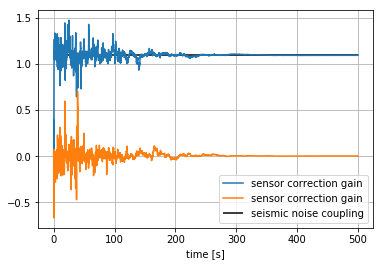

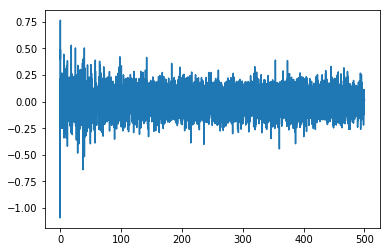

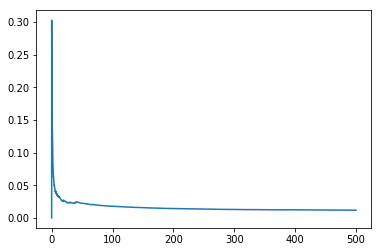

In [133]:
plt.plot(t,aa, label="sensor correction gain")
plt.plot(t,aa1, label="sensor correction gain")
plt.hlines(1.1, min(t), max(t), label="seismic noise coupling")
plt.legend(loc=0)
plt.xlabel("time [s]")
plt.grid()
plt.figure()
plt.plot(t,ee)
np.average(aa[1000:8000])
plt.figure()
plt.plot(t,cost)

In [10]:
from scipy.linalg import svd
input=x_seismic[0:10]
input = np.matrix(input).T
R = input*input.T

max(np.linalg.eigvals(input*input.T).real)
# rms(x_seismic[0:100])**2
# np.trace(input.T*input)

6.322032719804595

In [11]:
?lms_update